In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

device = torch.device('cuda:0')

In [2]:
class PUBG_imglike_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        def transfrom2imglike(input):
            output = np.zeros((3,32,32))
            temp = np.array(input)
            for x in range(23):
                for y in range(23):
                    if(x == y):
                        output[0][x][y] = temp[x]
                        output[1][x][y] = temp[x]
                        output[2][x][y] = temp[x]
            return output
        # get one line in csv
        player_id = self.frame.iloc [idx, 0]
        player_stats = self.frame.iloc [idx, [x for x in range(3, 27) if x != 15]].values.astype(np.int_)
        player_stats = torch.tensor(transfrom2imglike(player_stats))
        win_place_perc = torch.tensor(self.frame.iloc [idx, 28])
        if self.transform:
            player_stats = self.transform(player_stats)
        sample = {
            "player_id": player_id, 
            "player_stats": player_stats,
            "win_place_perc": win_place_perc
        }
        return sample
    
def get_dataset(csv_file, train_dataset_size_ratio, batch_size):
    dataset = PUBG_imglike_dataset(csv_file)
    #  `torch.utils.data.random_split` meets server problem and lead to CRASH
    # see also:
    # - a denied fix PR for this problem: https://github.com/pytorch/pytorch/pull/9237 
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor((1-train_dataset_size_ratio) * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print("load dataset: train dataset: {}, test dataset: {}.".format(len(train_loader)*batch_size, len(test_loader)*batch_size))
    return (train_loader, test_loader)

# load dataset
csv_file = 'train_small.csv'
train_dataset_size_ratio = 0.9
batch_size = 128
train_loader, test_loader = get_dataset(csv_file, train_dataset_size_ratio, batch_size)

load dataset: train dataset: 1152, test dataset: 128.


In [3]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    # train the model using minibatch
    for i, data in enumerate(train_loader):
        stats, prec = data['player_stats'], data['win_place_perc']
        stats, prec = stats.to(torch.float32).to(device), prec.to(device)

        # forward
        outputs = model(stats)
        loss = loss_func(outputs, prec)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        #if (i + 1) % 10 == 0:
        #    print ("Step [{}/{}] Train Loss: {:.4f}".format(i+1, len(train_loader), loss.item()))
    #print ("Train Loss: {:.4f}".format(loss.item()))
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):

    model.eval()
    with torch.no_grad():
        loss = 0
        total = 0
        
        for i, data in enumerate(val_loader):
            stats, prec = data['player_stats'], data['win_place_perc']
            stats, prec = stats.to(torch.float32).to(device), prec.to(device)

            outputs = model(stats)

            
            loss += (torch.abs(torch.t(outputs) - prec)).sum()
            total += prec.size(0)

            
        accuracy = loss / total
        #print('Test Loss: {:.4f}'.format(accuracy))
        return accuracy
    
def fit(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")

In [5]:
# Load necessary modules here
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import os


class Bottleneck(nn.Module):
    '''
        the above mentioned bottleneck, including two conv layer, one's kernel size is 1×1, another's is 3×3

        after non-linear operation, concatenate the input to the output
    '''
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        
        # input and output are concatenated here
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    '''
        transition layer is used for down sampling the feature
        
        when compress rate is 0.5, out_planes is a half of in_planes
    '''
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        
        out = self.conv(F.relu(self.bn(x)))
        # use average pooling change the size of feature map here
        out = F.avg_pool2d(out, 2)
        return out 

    
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        '''
        Args:
            block: bottleneck
            nblock: a list, the elements is number of bottleneck in each denseblock
            growth_rate: channel size of bottleneck's output
            reduction: 
        '''
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)
        
        # a DenseBlock and a transition layer
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes
        
        # a DenseBlock and a transition layer
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # a DenseBlock and a transition layer
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        # the channel size is superposed, mutiply by reduction to cut it down here, the reduction is also known as compress rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        # only one DenseBlock 
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        # the last part is a linear layer as a classifier
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        
        # number of non-linear transformations in one DenseBlock depends on the parameter you set
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [6]:
# start training and testing
#densenet = DenseNet(Bottleneck, [2, 5, 4, 6], num_classes=1)
densenet52 = DenseNet(Bottleneck, [6, 6, 6, 6], num_classes=1)
print(densenet52)

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [7]:
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32

# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:0')

optimizer = torch.optim.Adam(densenet52.parameters(), lr=lr)

Epoch 10/100
Train Loss: 0.0960
Test Loss: 0.2779
Epoch 20/100
Train Loss: 0.0964
Test Loss: 0.2791
Epoch 30/100
Train Loss: 0.0930
Test Loss: 0.2781
Epoch 40/100
Train Loss: 0.0932
Test Loss: 0.2783
Epoch 50/100
Train Loss: 0.0892
Test Loss: 0.2785
Epoch 60/100
Train Loss: 0.0912
Test Loss: 0.2782
Epoch 70/100
Train Loss: 0.0954
Test Loss: 0.2777
Epoch 80/100
Train Loss: 0.0921
Test Loss: 0.2776
Epoch 90/100
Train Loss: 0.0898
Test Loss: 0.2778
Epoch 100/100
Train Loss: 0.0881
Test Loss: 0.2787


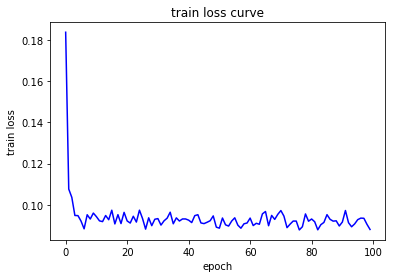

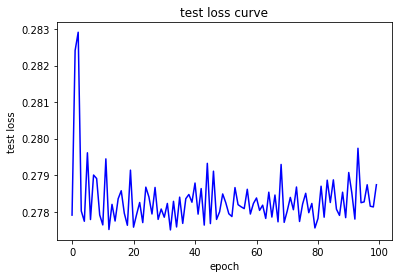

In [8]:
fit(densenet52, num_epochs, optimizer, device)